In [2]:
import logging
import os
import gc

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from data.data_preparer import DataPreparer
from src.data.data_reader import DataReader
from src.predictor.multilayer_perceptron import MultiLayerPerceptronPredictor
from tools.RestaurantReviewsDataset import RestaurantReviewsDataset
from tools.config_parser import ConfigParser

logging.basicConfig(level=logging.INFO)

while str(os.getcwd())[-3:] != 'src':  # Execute from src-directory root
    os.chdir('..')

In [3]:
_, (b_test, r_test, u_test) = DataReader().read_data()

Could not reach caches!                                                               
Reading files from disk:  60%|██████    | 3/5 [04:13<03:02, 91.47s/it, current: normalising] 
Applying normalisation for user profiles based on labels:   0%|          | 0/98 [00:00<?, ?it/s]
Applying normalisation for user profiles based on labels:   1%|          | 1/98 [00:00<00:33,  2.90it/s]
Applying normalisation for user profiles based on labels:   7%|▋         | 7/98 [00:00<00:04, 19.47it/s]
Applying normalisation for user profiles based on labels:  13%|█▎        | 13/98 [00:00<00:02, 31.26it/s]
Applying normalisation for user profiles based on labels:  19%|█▉        | 19/98 [00:00<00:01, 39.60it/s]
Applying normalisation for user profiles based on labels:  27%|██▋       | 26/98 [00:00<00:01, 46.90it/s]
Applying normalisation for user profiles based on labels:  34%|███▎      | 33/98 [00:00<00:01, 51.77it/s]
Applying normalisation for user profiles based on labels:  40%|███▉      | 39/98 [00:00<

In [4]:
def load_model_with_test_data(model_path: os.PathLike, b_test_f, r_test_f, u_test_f):

    # Create valid trained model
    input_size = MultiLayerPerceptronPredictor.get_input_size_from_file(model_path)
    trained_optimizer = optim.Adam(MultiLayerPerceptronPredictor(input_size=input_size, output_size=1).parameters(), lr=0.002)  # Optimizer doesn't matter anymore
    trained_model, _ = MultiLayerPerceptronPredictor.load(trained_optimizer, model_path)

    # Create associated test data for validation
    input_test, output_test = DataPreparer.transform_data(b_test_f, r_test_f, u_test_f, trained_model.user_profiles_params, trained_model.business_profiles_params)

    return trained_model, (input_test, output_test)

def find_worst_model_with_index(model_list) -> tuple[float, int]:
    highest_loss = max([model_f[1] for model_f in model_list])
    corresponding_index = [i for i, model_f in enumerate(model_list) if model_f[1] == highest_loss][0]
    return highest_loss, corresponding_index


def get_all_models_with_loss():
    models_dir = [dir_entry.path for dir_entry in list(os.scandir(ConfigParser().get_value("predictor_model", "model_dir"))) if dir_entry.path.endswith('.pt')]
    models_with_loss_f = []
    for _ in range(min(len(models_dir), 5)):
        models_with_loss_f.append((None, 99))
    for model_path in tqdm(models_dir, desc="Loading in models"):

        model_f, train_test_data_f = load_model_with_test_data(model_path, b_test, r_test, u_test)

        highest_loss, highest_index = find_worst_model_with_index(models_with_loss_f)
        current_loss = min(model_f.loss_history)
        if current_loss < highest_loss:
            models_with_loss_f[highest_index] = (model_f, current_loss, train_test_data_f)
    models_with_loss_f = sorted(models_with_loss_f, key=lambda data: data[1])
    return models_with_loss_f

In [5]:
models_with_loss = get_all_models_with_loss()

results = []

for model, _, train_test_data in models_with_loss:
    logging.info(f"Testing model with User Profiles: {model.user_profiles_params} and Business Profiles: {model.business_profiles_params}")
    model.eval()  # Prepare layers of model for evaluation
    with torch.no_grad():
        testX, testY = train_test_data

        testX = testX.head(500)
        testY = testY.head(500)

        dl = RestaurantReviewsDataset(testX.to_numpy(), testY.to_numpy())
        test_loader = DataLoader(dl, batch_size=500)
        for x, y in test_loader:
            # Prepare data
            x, y = DataPreparer.get_tensor_for_ml(x, y)
            # Compute predictions and loss

            predictions = model(x)
            predictions = predictions.cpu().detach().numpy().squeeze().transpose()
            y = y.cpu().detach().numpy().squeeze().transpose()
            result = pd.DataFrame(data=[predictions, y]).transpose()
            result.columns = ['predicted', 'actual']
            result['predicted'] = result['predicted'].transform(lambda x: round(x * 4 + 1))
            result['actual'] = result['actual'].transform(lambda x: int(x * 4 + 1))
            result['difference'] = abs(result['predicted'] - result['actual'])
            results.append(result)

Loading in models:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:Model loaded from predictor/Models/mlp\mlp_2023-05-09_00h45__EPOCHS=100_LOSS=0.0851.pt.
INFO:root:Splitting in generation and prediction sets
INFO:root:Creating User Profile
INFO:root:Finished reading in data, starting NLP...
INFO:root:Loading in all scores...
INFO:root:Merging Reviews...
INFO:root:Loading in NLP model...
INFO:root:Calculating bert_scores...


Pandas Apply:   0%|          | 0/472178 [00:00<?, ?it/s]

INFO:root:creating user profiles from bert_scores...
INFO:root:Exploding bert_scores (late) & normalizing user profiles...


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Saving user profiles...
INFO:root:Saved user profiles with name: profile_tmp.parquet
INFO:root:Creating Restaurant Profile
INFO:root:Finished reading in data, starting NLP...
INFO:root:Loading in all scores...
INFO:root:Merging Reviews...
INFO:root:Loading in NLP model...
INFO:root:Calculating bert_scores...


Pandas Apply:   0%|          | 0/472178 [00:00<?, ?it/s]

INFO:root:creating user profiles from bert_scores...
INFO:root:Exploding bert_scores (late) & normalizing business profiles...


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Saving business profiles...
INFO:root:Saved business profiles with name: profile_tmp.parquet
INFO:root:Transforming to ML input
INFO:root:Testing model with User Profiles: {'current_model_name': 'online_model_400top_97.bert', 'use_sentiment_in_scores': False, 'approx_mode': False, 'approx_normalization': True, 'approx_amount_top_n': 5, 'filter_useful_topics': False} and Business Profiles: {'current_model_name': 'online_model_400top_97.bert', 'use_sentiment_in_scores': False, 'approx_mode': False, 'approx_normalization': True, 'approx_amount_top_n': 5, 'filter_useful_topics': False}


Histogram of differences between prediction and actual:
Models used: {'current_model_name': 'online_model_400top_97.bert', 'use_sentiment_in_scores': False, 'approx_mode': False, 'approx_normalization': True, 'approx_amount_top_n': 5, 'filter_useful_topics': False}  |  {'current_model_name': 'online_model_400top_97.bert', 'use_sentiment_in_scores': False, 'approx_mode': False, 'approx_normalization': True, 'approx_amount_top_n': 5, 'filter_useful_topics': False}


,predicted,actual,difference
0,2,2,0
1,4,4,0
2,4,4,0
3,3,4,1
4,4,4,0
...,...,...,...
495,2,2,0
496,2,2,0
497,3,4,1
498,2,2,0


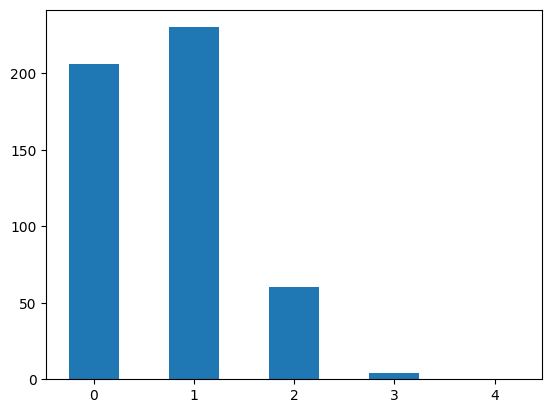

In [7]:
index = 0
result = results[index]
model: MultiLayerPerceptronPredictor = models_with_loss[index][0]
print("Histogram of differences between prediction and actual:")
print(f"Models used: {model.user_profiles_params}  |  {model.business_profiles_params}")
plt.hist(result['difference'], bins=[0, 1, 2, 3, 4, 5], align='left', rwidth=0.5)
result

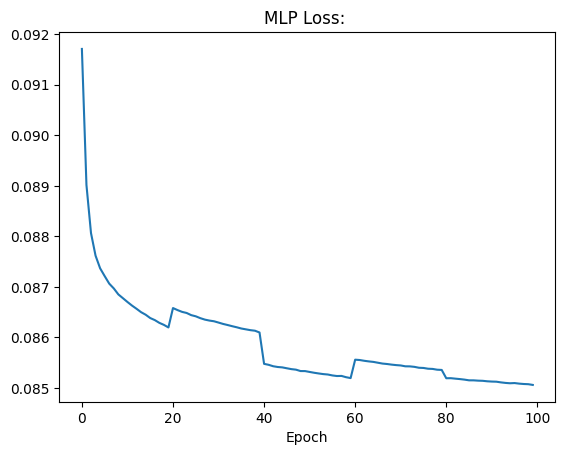

In [8]:
model.plot_loss_progress()[0]